# Valuing Diamonds
#### Alex Melnick - alme9138

## Problem

This will be a regression project seeking to project the price of a diamond based on its other attributes. This is an interesting topic to me because the diamond market is often discussed as one based on artificial scarcity. I am interested to see how closely overall price correlates to each component measurement. Which attributes contribute most and least to the overall price? Is it a linear relationship or does a dollar go further at one end of the scale or the other? This could be useful information for those looking to dazzle on a budget or who are jewel thieves that wish to better target and select their ill-gotten gains.

I will initially take both training and test data from a dataset comprised of 2017 diamond prices. If I can find a price list from another year, I would like to use the candidate models developed in my project to predict current diamond prices. If successful, there should be a predictable difference corresponding to changes in the market and inflation during the intervening time interval.

## Dataset

I will be exploring a dataset comprised of diamond prices. This was obtained from [Kaggle](https://www.kaggle.com/datasets/shivam2503/diamonds) and is based on the 2017 Tiffany's pricelist. The dataset is in tabulated form and consists of 53,940 instances each with 10 attributes:

1. **price** price in US dollars (326 to 18,823) - Continuous

2. **carat** weight of the diamond (0.2 to5.01) - Continuous

3. **cut** quality of the cut (Fair, Good, Very Good, Premium, Ideal) - Ordinal Categorical

4. **color** diamond colour, from J (worst) to D (best) - Ordinal Categorical

5. **clarity** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) - Ordinal Categorical

6. **x** length in mm (0 to 10.74) - Continuous

7. **y** width in mm (0 to 58.9) - Continuous

8. **z** depth in mm (0 to 31.8) - Continuous

9. **depth** total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79) - Continuous

10. **table** width of top of diamond relative to widest point (43 to 95) - Continuous

Little cleaning was required of the dataset. There appear to be no missing values. I did need to drop the index column and convert the ordinal categorical data to the appropriate type in pandas (cut, color, and clarity). I performed a basic EDA by plotting a histogram (continuous values) or value count bar plot (categorical values) to get a sense of the shape of the data and to note any outliers. Based on a visual analysis, the dataset skews towards the lighter, less expensive diamonds, and higher quality cut diamonds. No obvious outliers were observed.


In [3]:
import copy
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
import patsy
from sklearn import datasets
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn import linear_model,metrics
# Set color map to have light blue background
sns.set()

In [4]:
df = pd.read_csv('diamonds.csv')
df = df.drop('Unnamed: 0', 1)
df.head(10)

C:\Users\melni\AppData\Local\Temp\ipykernel_20752\636088786.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('Unnamed: 0', 1)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [5]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
#Test for missing values
df.isnull().values.any()

False

In [7]:
#Change type of caterical data to category and order
df.cut.astype(pd.api.types.CategoricalDtype(categories = ["Fair", "Good", "Very Good", "Premium", "Ideal"], ordered = True))
df.color.astype(pd.api.types.CategoricalDtype(categories = ["J", "I", "H", "G", "F", "E", "D"], ordered = True))
df.clarity.astype(pd.api.types.CategoricalDtype(categories = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"], ordered = True));

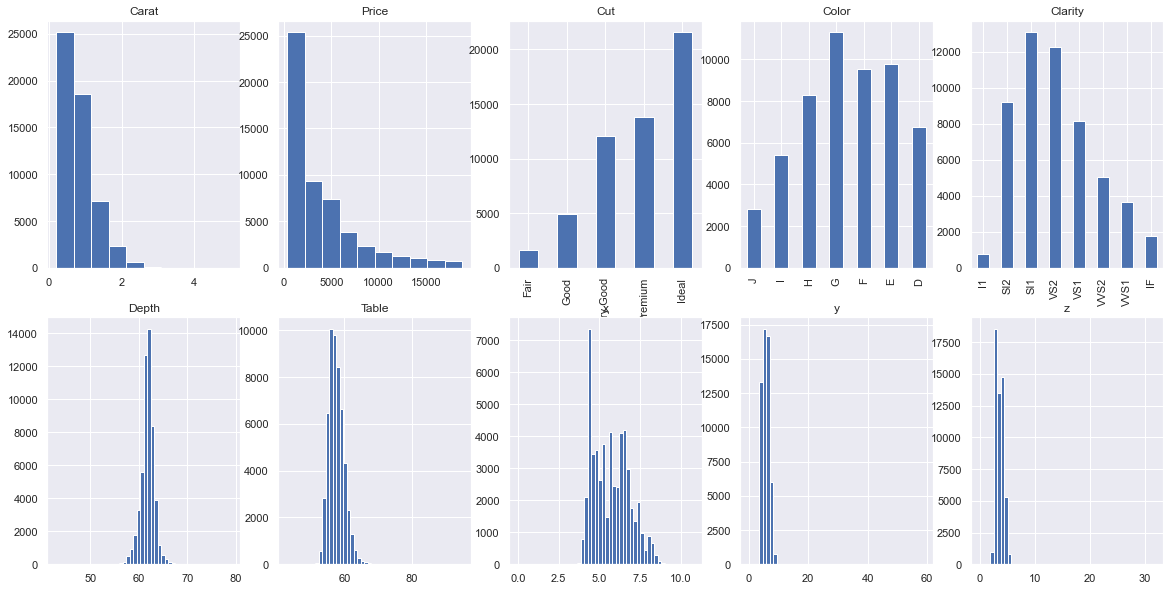

In [8]:
#Plot histograms or value counts plots for each attribute
fig, axs = plt.subplots(2, 5, figsize=(20,10))
axs[0,0].set_title('Carat')
axs[0,0].hist(df.carat);
axs[0,1].set_title('Price')
axs[0,1].hist(df.price);
axs[0,2].set_title('Cut')
df['cut'].value_counts()[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']].plot(kind='bar', ax=axs[0,2]);
axs[0,3].set_title('Color')
df['color'].value_counts()[["J", "I", "H", "G", "F", "E", "D"]].plot(kind='bar', ax=axs[0,3]);
axs[0,4].set_title('Clarity')
df['clarity'].value_counts()[["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]].plot(kind='bar', ax=axs[0,4]);
axs[1,0].set_title('Depth')
axs[1,0].hist(df.depth, bins=50);
axs[1,1].set_title('Table')
axs[1,1].hist(df.table, bins=50);
axs[1,2].set_title('x')
axs[1,2].hist(df.x, bins=50);
axs[1,3].set_title('y')
axs[1,3].hist(df.y, bins=50);
axs[1,4].set_title('z')
axs[1,4].hist(df.z, bins=50);

## Model Development

I initially performed an ordinary least squares regression using all predictors, assuming no interactions to identify predictors that did not contribute to price. This identified both y and z based on the $p > 0.05$ and a confidence interval that includes 0. Overall, this also provides a basic expectation for candidate models, with an $R^2$ value of 0.92. Initially I used the entire data set. Later, when I formally select a model, I will split the data into training and test sets.

In [9]:
#Perform OLS regression using all predictors
model_tr = smf.ols(formula='price~carat+cut+color+clarity+depth+table+x+y+z', data=df).fit()
model_tr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.688e+04
Date:                Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                        17:40:32   Log-Likelihood:            -4.5573e+05
No. Observations:               53940   AIC:                         9.115e+05
Df Residuals:                   53916   BIC:                         9.117e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2184.4774    408.197      5.352      0.000    1384.409    2984.546
cut[T.Good]        579.7514     33.592     17.259      0.000     513.911     645.592
cut[T.Ideal]       832.9118     33.407     24.932      0.000     767.433     898.391
cut[T.Premium]     762.1440     32.228     23.649      0.000     698.978     825.310
cut[T.Very Good]   726.7826     32.241     22.542      0.000     663.591     789.975
color[T.E]        -209.1181     17.893    -11.687      0.000    -244.189    -174.047
color[T.F]        -272.8538     18.093    -15.081      0.000    -308.316    -237.392
color[T.G]        -482.0389     17.716    -27.209      0.000    -516.763    -447.315
color[T.H]        -980.2667     18.836    -52.043      0.000   -1017.185    -943.348
color[T.I]       -1466.2445     21.162    -69.286      0.000   -1507.723   -1424.766
color[T.J]       -2369.3981     26.131    -90.674      0.000   -2420.615   -2318.181
clarity[T.IF]     5345.1022     51.024    104.757      0.000    5245.095    5445.110
clarity[T.SI1]    3665.4721     43.634     84.005      0.000    3579.949    3750.995
clarity[T.SI2]    2702.5863     43.818     61.677      0.000    2616.702    2788.471
clarity[T.VS1]    4578.3979     44.546    102.779      0.000    4491.087    4665.708
clarity[T.VS2]    4267.2236     43.853     97.306      0.000    4181.270    4353.177
clarity[T.VVS1]   5007.7590     47.160    106.187      0.000    4915.326    5100.192
clarity[T.VVS2]   4950.8141     45.855    107.967      0.000    4860.938    5040.690
carat             1.126e+04     48.628    231.494      0.000    1.12e+04    1.14e+04
depth              -63.8061      4.535    -14.071      0.000     -72.694     -54.918
table              -26.4741      2.912     -9.092      0.000     -32.181     -20.767
x                -1008.2611     32.898    -30.648      0.000   -1072.741    -943.781
y                    9.6089     19.333      0.497      0.619     -28.284      47.502
z                  -50.1189     33.486     -1.497      0.134    -115.752      15.515
==============================================================================
Omnibus:                    14433.356   Durbin-Watson:                   1.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           565680.446
Skew:                           0.577   Prob(JB):                         0.00
Kurtosis:                      18.823   Cond. No.                     7.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Correlation Matrix

Next I used a correlation matrix to identify predictors that are strongly correlated, indicating that they can be combined. Unsurprisingly, carat was strongly correlated with x, y, and z values. I will plan to use carat as an overall measure for the effect of these "size" predictors and drop the x, y, and z predictors from the model.

In [10]:
df.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


### Scatterplot Matrix

I plotted the remaining quantitative variables in a scatterplot matrix to get a general sense of any correlation. Price and carat appear to have a positive correlation that is linear (though potentially polynomial). Depth and table do not appear to have a strong correlation with price. I expect the best model will make use of the categorical variables.

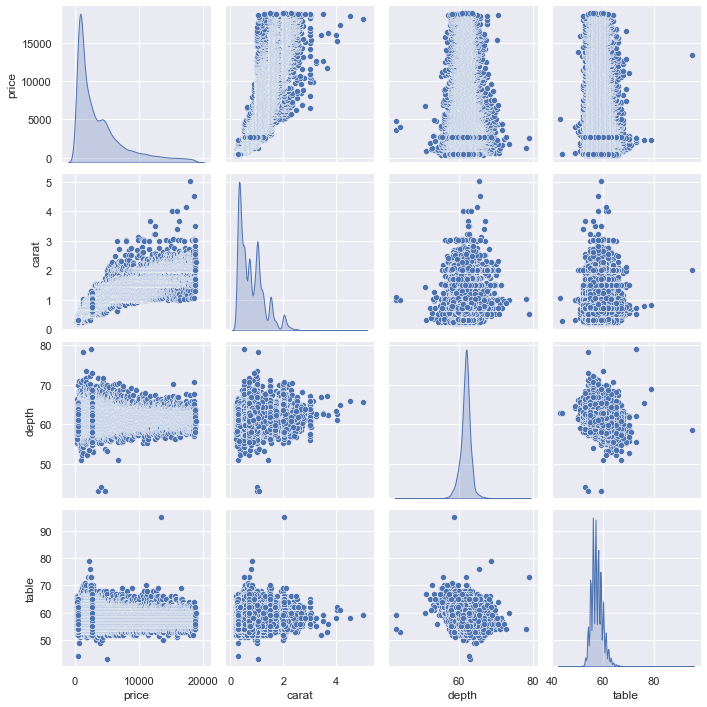

In [11]:
sns.pairplot(df[['price', 'carat', 'depth', 'table']], diag_kind='kde');

### Categorical Scatterplots

Using the base of a scatterplot comparing carat to price, I plotted each categorical value using hue. If a certain category routinely lies along a relatively higher or lower slope, this indicates that category has importance as a predictor. Higher quality ratings are at the bottom of the legend, lower quality at the top. From this, I can see that clarity is important to the price in a fairly organized manner. Higher quality color also leads to a higher price, but there is more mixing. Cut appears to be less conclusive.

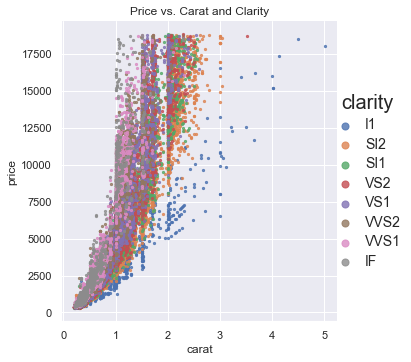

In [12]:
#plot carat vs. price with clarity hued
clarplot = sns.lmplot( x="carat", y="price", data=df, fit_reg=False, hue_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"], hue='clarity', legend=True, scatter_kws={"s": 5}).set(title='Price vs. Carat and Clarity');
plt.setp(clarplot._legend.get_title(), fontsize=20);
plt.setp(clarplot._legend.get_texts(), fontsize=14);
for lh in clarplot._legend.legendHandles: 
    lh._sizes = [50] 

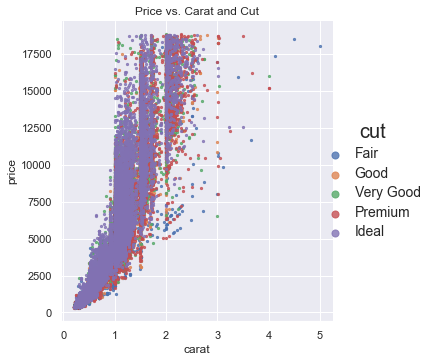

In [13]:
#plot carat vs. price with cut hued
cutplot = sns.lmplot( x="carat", y="price", data=df, fit_reg=False, hue_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"], hue='cut', legend=True, scatter_kws={"s": 5}).set(title='Price vs. Carat and Cut');
plt.setp(cutplot._legend.get_title(), fontsize=20);
plt.setp(cutplot._legend.get_texts(), fontsize=14);
for lh in cutplot._legend.legendHandles: 
    lh._sizes = [50] 

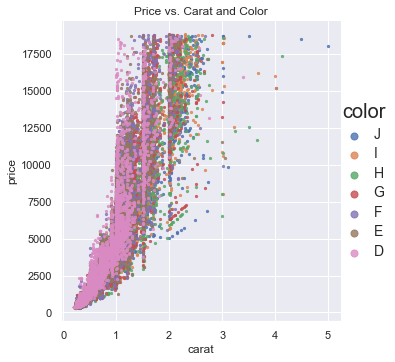

In [14]:
#plot carat vs. price with color hued
colplot = sns.lmplot( x="carat", y="price", data=df, fit_reg=False, hue_order = ["J", "I", "H", "G", "F", "E", "D"], hue='color', legend=True, scatter_kws={"s": 5}).set(title='Price vs. Carat and Color');
plt.setp(colplot._legend.get_title(), fontsize=20);
plt.setp(colplot._legend.get_texts(), fontsize=14);
for lh in colplot._legend.legendHandles: 
    lh._sizes = [50] 

### Model Selection

Based on my findings from the exploratory data analysis, I believe I will use a subset selection method to determine a good polynomial, linear model. Subset selection will be a good method because I have already decided to drop 3 of the predictors, leaving me with a $p$ of only 6. This is a low enough $p$ that a subset selection will remain efficient and complete. I will test the quality of the top candidate models with cross validation. With a relatively large data set, any overfitting should be evident.

In [15]:
param_list = ['carat', 'table', 'depth', 'cut', 'color', 'clarity']
r2_list_ind = []
best_models_ind = []
for k in range(len(param_list)):
    bestr2 = 0
    best_params = ''
    model_combos = itertools.combinations(param_list, k+1)
    test_params = ['+'.join(i) for i in model_combos]
    for test_param in test_params:
        curr_model = smf.ols(formula = 'price~' + test_param, data=df).fit()
        if curr_model.rsquared > bestr2:
            bestr2 = curr_model.rsquared
            best_params = test_param
    r2_list_ind.append(bestr2)
    best_models_ind.append(best_params)

I also suspect some predictors may be related, so I will also run the same subset selection with the * operator, replacing any models with an improved $r^2$

In [16]:
best_models = copy.copy(best_models_ind)
r2_list = copy.copy(r2_list_ind)
for k in range(len(param_list)):
    model_combos = itertools.combinations(param_list, k+1)
    test_params = ['*'.join(i) for i in model_combos]
    for test_param in test_params:
        curr_model = smf.ols(formula = 'price~' + test_param, data=df).fit()
        if curr_model.rsquared > r2_list[k]:
            r2_list[k] = curr_model.rsquared
            best_models[k] = test_param

['carat', 'carat+clarity', 'carat+color+clarity', 'carat+cut+color+clarity', 'carat+table+cut+color+clarity', 'carat+table+depth+cut+color+clarity']
[0.8493305264354858, 0.8948552484076189, 0.9139612406281767, 0.915940554017946, 0.9160129678812533, 0.916054322423958]
['carat', 'carat*clarity', 'carat*color*clarity', 'carat*cut*color*clarity', 'carat*table*cut*color*clarity', 'carat*table*depth*cut*color*clarity']
[0.8493305264354858, 0.908660479361379, 0.9382805875502322, 0.9424372697580661, 0.944376205819862, 0.9469584256217356]


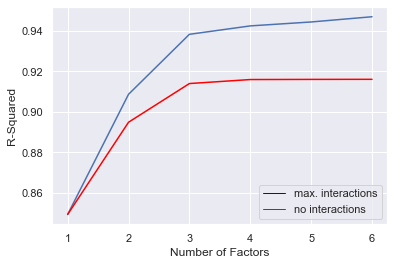

In [31]:
print(best_models_ind)
print(r2_list_ind)
print(best_models)
print(r2_list)

xticks = np.arange(1,7, 1)

plt.plot(xticks, r2_list);
plt.plot(xticks, r2_list_ind, color ='red');

plt.xlabel('Number of Factors')
plt.ylabel('R-Squared');

custom_lines = [plt.Line2D([0], [0], color='blue', lw=1),
                plt.Line2D([0], [0], color='red', lw=1)]
plt.legend(custom_lines,['max. interactions', 'no interactions']);

In fact, it appears that including interactions improved the performance of each on the entire data set, with all parameters included having the maximum $R^2$. However, these last few models will be immensely complex and uninterpretable for potentially little benefit in practice. I will conduct a cross validation test to compare the independent models to the dependent models. I will use a 50-50 split for train and test sets for the formal investigation, as well as a 3-way split using the sklearn cross_validation_score function for quick tests.

In [67]:
#Split dataset into test and train sets, each 50% of the dataset
X = df[param_list]
X = pd.get_dummies(data=X, drop_first=True)
y = df['price']
lr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)

In [100]:
#function that will take an sklearn model and return a Dataframe listing the features and coefficients
def summarize(model):
    coefs = np.array(model.coef_)
    coefs = np.insert(coefs,0,model.intercept_)
    features = np.array(model.feature_names_in_)
    features = np.insert(features,0,'Intercept')
    return pd.DataFrame({'Features': features, 'Coefficients' : coefs})

#function that will take a parameter string and the operator used and return a list of parameters (including dummy parameters)
def param_to_cols(parameterstring, operator):
    params = parameterstring.split(operator)
    return_list = []
    for param in params:
        if param == 'cut':
            return_list = return_list + ['cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good']
        elif param == 'clarity':
            return_list = return_list + ['clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']
        elif param == 'color':
            return_list = return_list + ['color_E', 'color_F', 'color_G', 'color_H', 'color_I','color_J']
        else:
            return_list = return_list + [param]
    return return_list

#function that will interpret the list of best models and return a fitted model based on the number of features desired and the predictors/targets passed
def create_model(train_preds, train_target, feature_list, k_num):
    train_set = train_preds[param_to_cols(feature_list[k_num-1], '+')]
    return lr.fit(train_set, train_target)

#function that will remove excess predictors based on selected number of features and based on the best subset list passed
def trim_preds(test_preds, feature_list, k_num):
    test_set = test_preds[param_to_cols(feature_list[k_num-1], '+')]
    return test_set

#iterate through models in the best_models_ind list (those with no interactions) and store the performance of each:
#train_r2_list holds R^2 scores for the training set
#test_r2_list holds R^2 scores for the test set
#model_details is a dictionary that holds the parameter string as keys and summaries of the related values (DataFrames) as values
train_r2_list = ['N/A']
test_r2_list = ['N/A']
model_details = {}
for i in range(6):
    curr_model = create_model(X_train, y_train, best_models_ind, i+1)
    curr_train_x = trim_preds(X_train, best_models_ind, i+1)
    curr_test_x = trim_preds(X_test, best_models_ind, i+1)
    train_r2_list.append((best_models_ind[i], metrics.r2_score(y_train, curr_model.predict(curr_train_x))))
    test_r2_list.append((best_models_ind[i], metrics.r2_score(y_test, curr_model.predict(curr_test_x))))
    model_details[best_models_ind[i]] = summarize(curr_model)




Having tested and stored the results of all the non-interactive models, I want to do a quick cross-validation test of the interactive models since those will require more resources to test. Using sklearn cross_validation_score, I determined that "carat * clarity" and "carat * color * clarity" hold the most promise. I will also more fully test "carat * clarity + carat * cut" as I suspec the triple interaction will be practically impossible to interpret without much improving the predictve power of the model.

In [21]:
#Cross validation to see which of these is worth investigating based on test R^2
for model in best_models:
    y, X = patsy.dmatrices("price ~" + model, data=df)
    print(model)
    print(cross_val_score(lr, X, y, cv=3))

carat
[-0.13319395  0.69010218 -0.6115836 ]
carat*clarity
[ 0.34115369  0.7765628  -0.3444758 ]
carat*color*clarity
[ 0.40300134  0.80661172 -0.26872628]
carat*cut*color*clarity
[-2.76111296e+19 -1.68302502e+18 -1.59736997e+23]
carat*table*cut*color*clarity
[-2.01168611e+18  5.22146190e-01 -9.30359379e-01]
carat*table*depth*cut*color*clarity
[-2.40409945e+16 -5.75875878e+12 -1.20110568e+18]


To test the models, I expand the training and test predictor sets by hand to include the interactions. I will be investigating the following models:
|Model|Coded Shorthand|
|-|-|
|carat * clarity|carclar|
|carat * clarity + carat * color|carclarpluscarcol|
|carat * clarity * color|carclarcol|
|carat * clarity + carat * color + cut + table + depth|carclarpluscarcolplus|
|carat * color * clarity + cut + table + depth|carclarcolplus|

In [101]:
#Based on cross validation, I will investigate (carat*clarity), (carat*clarity + carat*color), and (carat*color*clarity)
#Copy the base DataFrames and trim to match the desired features
X_train_carclar = copy.copy(X_train)
X_test_carclar = copy.copy(X_test)
X_train_carclarpluscarcol = copy.copy(X_train)
X_test_carclarpluscarcol = copy.copy(X_test)
X_train_carclarcol = copy.copy(X_train)
X_test_carclarcol = copy.copy(X_test)

X_train_carclar = X_train_carclar[param_to_cols('carat*clarity', '*')]
X_test_carclar = X_test_carclar[param_to_cols('carat*clarity', '*')]
X_train_carclarpluscarcol = X_train_carclarpluscarcol[param_to_cols('carat*clarity*color', '*')]
X_test_carclarpluscarcol = X_test_carclarpluscarcol[param_to_cols('carat*clarity*color', '*')]
X_train_carclarcol = X_train_carclarpluscarcol[param_to_cols('carat*clarity*color', '*')]
X_test_carclarcol = X_test_carclarpluscarcol[param_to_cols('carat*clarity*color', '*')]

In [102]:
clar_list = ['clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']
color_list = ['color_E', 'color_F', 'color_G', 'color_H', 'color_I','color_J']

for clar in clar_list:
    #mash up clarity and color
    X_train_carclar['carat:'+clar] = X_train_carclar['carat']*X_train_carclar[clar]
    X_test_carclar['carat:'+clar] = X_test_carclar['carat']*X_test_carclar[clar]
    #clarity and color are done, let's prepare the second set now
    X_train_carclarpluscarcol['carat:'+clar] = X_train_carclarpluscarcol['carat']*X_train_carclarpluscarcol[clar]
    X_test_carclarpluscarcol['carat:'+clar] = X_test_carclarpluscarcol['carat']*X_test_carclarpluscarcol[clar]
    #and the third
    X_train_carclarcol['carat:'+clar] = X_train_carclarcol['carat']*X_train_carclarcol[clar]
    X_test_carclarcol['carat:'+clar] = X_test_carclarcol['carat']*X_test_carclarcol[clar]
for col in color_list:
    X_train_carclarpluscarcol['carat:'+col] = X_train_carclarpluscarcol['carat']*X_train_carclarpluscarcol[col]
    X_test_carclarpluscarcol['carat:'+col] = X_test_carclarpluscarcol['carat']*X_test_carclarpluscarcol[col]
    #now the second is done, finishing the third
    X_train_carclarcol['carat:'+col] = X_train_carclarcol['carat']*X_train_carclarcol[col]
    X_test_carclarcol['carat:'+col] = X_test_carclarcol['carat']*X_test_carclarcol[col]
for clar in clar_list:
    for col in color_list:
        X_train_carclarcol[clar+':'+col] = X_train_carclarcol[clar]*X_train_carclarcol[col]
        X_test_carclarcol[clar+':'+col] = X_test_carclarcol[clar]*X_test_carclarcol[col]
        X_train_carclarcol['carat:'+clar+':'+col] = X_train_carclarcol[clar+':'+col]*X_train_carclarcol['carat']
        X_test_carclarcol['carat:'+clar+':'+col] = X_test_carclarcol[clar+':'+col]*X_test_carclarcol['carat']
#Now make carat*clarity + carat*color + (other 3 predictors) and c*c + c*c + c*c + (other 2)
X_train_carclarpluscarcolplus = copy.copy(X_train_carclarpluscarcol)
X_test_carclarpluscarcolplus = copy.copy(X_test_carclarpluscarcol)
X_train_carclarcolplus = copy.copy(X_train_carclarcol)
X_test_carclarcolplus = copy.copy(X_test_carclarcol)
X_train_carclarpluscarcolplus['table'] = X_train['table']
X_test_carclarpluscarcolplus['table'] = X_test['table']
X_train_carclarpluscarcolplus['depth'] = X_train['depth']
X_test_carclarpluscarcolplus['depth'] = X_test['depth']
X_train_carclarcolplus['table'] = X_train['table']
X_test_carclarcolplus['table'] = X_test['table']
X_train_carclarcolplus['depth'] = X_train['depth']
X_test_carclarcolplus['depth'] = X_test['depth']
for cut in ['cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good']:
    X_train_carclarpluscarcolplus[cut] = X_train[cut]
    X_test_carclarpluscarcolplus[cut] = X_test[cut]
    X_train_carclarcolplus[cut] = X_train[cut]
    X_test_carclarcolplus[cut] = X_test[cut]

In [103]:
#carat*clarity
model_carclar = lr.fit(X_train_carclar, y_train)
train_r2_list.append(('carat*clarity', metrics.r2_score(y_train, model_carclar.predict(X_train_carclar))))
test_r2_list.append(('carat*clarity', metrics.r2_score(y_test, model_carclar.predict(X_test_carclar))))
model_details['carat*clarity'] = summarize(model_carclar)
#carat*clarity+carat*color
model_carclarpluscarcol = lr.fit(X_train_carclarpluscarcol, y_train)
train_r2_list.append(('carat*clarity+carat*color', metrics.r2_score(y_train, model_carclarpluscarcol.predict(X_train_carclarpluscarcol))))
test_r2_list.append(('carat*clarity+carat*color', metrics.r2_score(y_test, model_carclarpluscarcol.predict(X_test_carclarpluscarcol))))
model_details['carat*clarity+carat*color'] = summarize(model_carclarpluscarcol)
#carat*color*clarity
model_carclarcol = lr.fit(X_train_carclarcol, y_train)
train_r2_list.append(('carat*clarity*color', metrics.r2_score(y_train, model_carclarcol.predict(X_train_carclarcol))))
test_r2_list.append(('carat*clarity*color', metrics.r2_score(y_test, model_carclarcol.predict(X_test_carclarcol))))
model_details['carat*clarity*color'] = summarize(model_carclarcol)
#carat*color+carat*clarity+cut+table+depth
model_carclarpluscarcolplus = lr.fit(X_train_carclarpluscarcolplus, y_train)
train_r2_list.append(('carat*clarity+carat*color+cut+table+depth', metrics.r2_score(y_train, model_carclarpluscarcolplus.predict(X_train_carclarpluscarcolplus))))
test_r2_list.append(('carat*clarity+carat*color+cut+table+depth', metrics.r2_score(y_test, model_carclarpluscarcolplus.predict(X_test_carclarpluscarcolplus))))
model_details['carat*clarity+carat*color+cut+table+depth'] = summarize(model_carclarpluscarcolplus)
#carat*color*clarity+cut+table+depth
model_carclarcolplus = lr.fit(X_train_carclarcolplus, y_train)
train_r2_list.append(('carat*color*clarity+cut+table+depth', metrics.r2_score(y_train, model_carclarcolplus.predict(X_train_carclarcolplus))))
test_r2_list.append(('carat*color*clarity+cut+table+depth', metrics.r2_score(y_test, model_carclarcolplus.predict(X_test_carclarcolplus))))
model_details['carat*color*clarity+cut+table+depth'] = summarize(model_carclarcolplus)

In [104]:
test_r2_list

['N/A',
 ('carat', 0.8481242962072413),
 ('carat+clarity', 0.8940802386678173),
 ('carat+color+clarity', 0.9135087184800096),
 ('carat+cut+color+clarity', 0.915642720775098),
 ('carat+table+cut+color+clarity', 0.9156847830775754),
 ('carat+table+depth+cut+color+clarity', 0.9157336485382679),
 ('carat*clarity', 0.9082985399475849),
 ('carat*clarity+carat*color', 0.9306630262053311),
 ('carat*clarity*color', 0.9378315786539743),
 ('carat*clarity+carat*color+cut+table+depth', 0.9329558382024644),
 ('carat*color*clarity+cut+table+depth', 0.9401280060463929)]

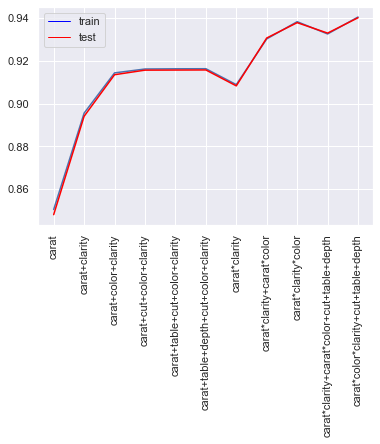

In [105]:
to_train_plot = train_r2_list[1:]
to_test_plot = test_r2_list[1:]
x1, y1 = zip(*to_train_plot)
x2, y2 = zip(*to_test_plot)
plt.plot(x1, y1);
plt.plot(x1, y2, color='red');
plt.xticks(rotation = 90);

custom_lines = [plt.Line2D([0], [0], color='blue', lw=1),
                plt.Line2D([0], [0], color='red', lw=1)]
plt.legend(custom_lines,['train', 'test']);

As shown in the graph above, there does not seem to be much evidence of overfitting between the training and test sets. Though the models that include three interactive terms (carat * color * clarity) have the highest $R^2$ values, I will select (carat * clarity + carat * color) as my primary model going forward since my goal is inference, not prediction. With 3 degrees of interactions, the features list becomes unwieldy and many of the features gain a p-value greater than 0.05.

In a final attempt to boost the model's predictive power, I want to test the influence of polynomial features. Since carat is the most significant predictor and carat/color are categorical, I will focus on various polynomials of carat.

In [106]:
X_train_half = copy.copy(X_train_carclarpluscarcol)
X_test_half = copy.copy(X_test_carclarpluscarcol)
X_train_square= copy.copy(X_train_carclarpluscarcol)
X_test_square = copy.copy(X_test_carclarpluscarcol)

X_train_half['sqrt(carat)'] = np.sqrt(X_train_half['carat'])
X_test_half['sqrt(carat)'] = np.sqrt(X_test_half['carat'])
X_train_square['carat^2'] = X_train_square['carat']**2
X_test_square['carat^2'] = X_test_square['carat']**2

#carat*clarity+carat*color+carat^0.5
model_half = lr.fit(X_train_half, y_train)
train_r2_list.append(('carat*clarity+carat*color+carat^0.5', metrics.r2_score(y_train, model_half.predict(X_train_half))))
test_r2_list.append(('carat*clarity+carat*color+carat^0.5', metrics.r2_score(y_test, model_half.predict(X_test_half))))
model_details['carat*clarity+carat*color+carat^0.5'] = summarize(model_half)
#carat*clarity+carat*color+carat^2
model_square = lr.fit(X_train_square, y_train)
train_r2_list.append(('carat*clarity+carat*color+carat^2', metrics.r2_score(y_train, model_square.predict(X_train_square))))
test_r2_list.append(('carat*clarity+carat*color+carat^2', metrics.r2_score(y_test, model_square.predict(X_test_square))))
model_details['carat*clarity+carat*color+carat^2'] = summarize(model_square)

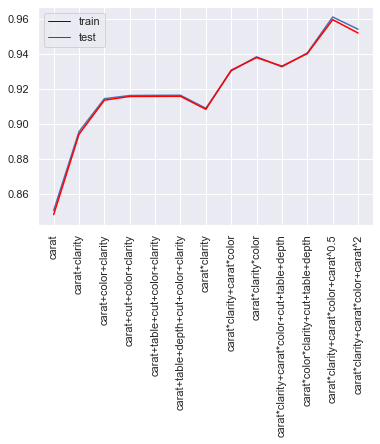

In [107]:
to_train_plot = train_r2_list[1:]
to_test_plot = test_r2_list[1:]
x1, y1 = zip(*to_train_plot)
x2, y2 = zip(*to_test_plot)
plt.plot(x1, y1);
plt.plot(x1, y2, color='red');
plt.xticks(rotation = 90);

custom_lines = [plt.Line2D([0], [0], color='blue', lw=1),
                plt.Line2D([0], [0], color='red', lw=1)]
plt.legend(custom_lines,['train', 'test']);

This graph shows that adding a $\sqrt{carat}$ element to the model improves the $R^2$ score by approximately 0.03. This is not insignificant. Higher-order polynomial elements do not improve the model further.

One last test: Since the goal of this regression is inference, a simpler model would be preferable (this is--minimize interactions.) I will also investigate the effect of adding the $\sqrt{carat}$ element to the most promising non-interactive models.

In [108]:
#first with all terms
X_train_half_ind = copy.copy(X_train)
X_test_half_ind = copy.copy(X_test)
X_train_half_ind['sqrt(carat)'] = np.sqrt(X_train_half_ind['carat'])
X_test_half_ind['sqrt(carat)'] = np.sqrt(X_test_half_ind['carat'])
model_half_ind = lr.fit(X_train_half_ind, y_train)
train_r2_list.append(('carat+carat^0.5+color+clarity+cut+table+depth', metrics.r2_score(y_train, model_half_ind.predict(X_train_half_ind))))
test_r2_list.append(('carat+carat^0.5+color+clarity+cut+table+depth', metrics.r2_score(y_test, model_half_ind.predict(X_test_half_ind))))
model_details['carat+carat^0.5+color+clarity+cut+table+depth'] = summarize(model_half_ind)

In [109]:
#and now with the "four c's"
X_train_half_simple = X_train_half_ind.drop(['table', 'depth'], axis=1)
X_test_half_simple = X_test_half_ind.drop(['table', 'depth'], axis=1)
model_half_simple = lr.fit(X_train_half_simple, y_train)
train_r2_list.append(('carat+carat^0.5+color+clarity+cut', metrics.r2_score(y_train, model_half_simple.predict(X_train_half_simple))))
test_r2_list.append(('carat+carat^0.5+color+clarity+cut', metrics.r2_score(y_test, model_half_simple.predict(X_test_half_simple))))
model_details['carat+carat^0.5+color+clarity+cut'] = summarize(model_half_simple)

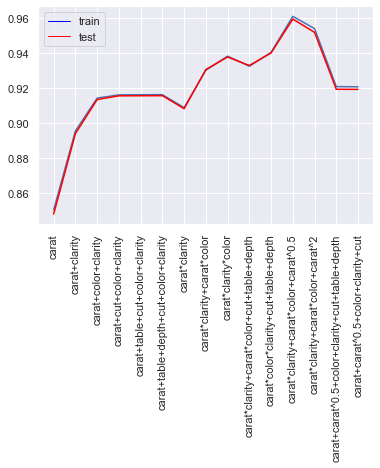

In [110]:
to_train_plot = train_r2_list[1:]
to_test_plot = test_r2_list[1:]
x1, y1 = zip(*to_train_plot)
x2, y2 = zip(*to_test_plot)
plt.plot(x1, y1);
plt.plot(x1, y2, color='red');
plt.xticks(rotation = 90);

custom_lines = [plt.Line2D([0], [0], color='blue', lw=1),
                plt.Line2D([0], [0], color='red', lw=1)]
plt.legend(custom_lines,['train', 'test']);

Both of the non-interactive models perform 0.05 worse than the best model in terms of $R^2$. However, that is an acceptable tradeoff since my goal is inference. I will publish both models.

Best model for inference, with an $R^2$ of approximately 0.92: 

|    | Feature       |   Coefficient  |
|---:|:--------------|---------------:|
|  0 | Intercept     |      -4133.85  |
|  1 | carat         |      12683.2   |
|  2 | cut_Good      |        605.443 |
|  3 | cut_Ideal     |        891.796 |
|  4 | cut_Premium   |        749.356 |
|  5 | cut_Very Good |        765.298 |
|  6 | color_E       |       -216.682 |
|  7 | color_F       |       -268.101 |
|  8 | color_G       |       -478.187 |
|  9 | color_H       |       -986.394 |
| 10 | color_I       |      -1491.48  |
| 11 | color_J       |      -2351.42  |
| 12 | clarity_IF    |       5354.24  |
| 13 | clarity_SI1   |       3645     |
| 14 | clarity_SI2   |       2674.89  |
| 15 | clarity_VS1   |       4575.06  |
| 16 | clarity_VS2   |       4258.89  |
| 17 | clarity_VVS1  |       4969     |
| 18 | clarity_VVS2  |       4908.48  |
| 19 | sqrt(carat)   |      -7223.69  |

Best model for prediction, with an $R^2$ of approximately 0.96:

|    | Feature            |   Coefficient  |
|---:|:-------------------|---------------:|
|  0 | Intercept          |     10792.2    |
|  1 | carat              |     16138.6    |
|  2 | clarity_IF         |     -5167.04   |
|  3 | clarity_SI1        |     -4053.27   |
|  4 | clarity_SI2        |     -3410.62   |
|  5 | clarity_VS1        |     -4494.97   |
|  6 | clarity_VS2        |     -4309.55   |
|  7 | clarity_VVS1       |     -4925.45   |
|  8 | clarity_VVS2       |     -4826.71   |
|  9 | color_E            |        86.9598 |
| 10 | color_F            |        31.9883 |
| 11 | color_G            |       258.312  |
| 12 | color_H            |       522.668  |
| 13 | color_I            |       681.04   |
| 14 | color_J            |      1229.55   |
| 15 | carat:clarity_IF   |     10983.8    |
| 16 | carat:clarity_SI1  |      6317.42   |
| 17 | carat:clarity_SI2  |      4774.94   |
| 18 | carat:clarity_VS1  |      8037.26   |
| 19 | carat:clarity_VS2  |      7389.61   |
| 20 | carat:clarity_VVS1 |      9908.02   |
| 21 | carat:clarity_VVS2 |      9351.86   |
| 22 | carat:color_E      |      -372.779  |
| 23 | carat:color_F      |      -469.281  |
| 24 | carat:color_G      |     -1138.81   |
| 25 | carat:color_H      |     -1996.39   |
| 26 | carat:color_I      |     -2711.78   |
| 27 | carat:color_J      |     -3945.89   |
| 28 | sqrt(carat)        |    -23520.5    |

Full model $R^2$ Results

|    | Model                                         |   $R^2$ Train|   $R^2$ test |
|---:|:----------------------------------------------|------------:|-----------:|
|  0 | carat                                         |    0.85052  |   0.848124 |
|  1 | carat+clarity                                 |    0.895576 |   0.89408  |
|  2 | carat+color+clarity                           |    0.914368 |   0.913509 |
|  3 | carat+cut+color+clarity                       |    0.916185 |   0.915643 |
|  4 | carat+table+cut+color+clarity                 |    0.916283 |   0.915685 |
|  5 | carat+table+depth+cut+color+clarity           |    0.916316 |   0.915734 |
|  6 | carat*clarity                                 |    0.908884 |   0.908299 |
|  7 | carat*clarity+carat*color                     |    0.930232 |   0.930663 |
|  8 | carat*clarity*color                           |    0.938297 |   0.937832 |
|  9 | carat*clarity+carat*color+cut+table+depth     |    0.932545 |   0.932956 |
| 10 | carat*color*clarity+cut+table+depth           |    0.94048  |   0.940128 |
| 11 | carat*clarity+carat*color+carat^0.5           |    0.96103  |   0.959492 |
| 12 | carat*clarity+carat*color+carat^2             |    0.954045 |   0.951891 |
| 13 | carat+carat^0.5+color+clarity+cut+table+depth |    0.920903 |   0.919384 |
| 14 | carat+carat^0.5+color+clarity+cut             |    0.920818 |   0.919335 |